Ciclo Crisis 52-55 ignorado (fuera de rango)
Ciclo Expansión 56-69 ignorado (fuera de rango)
Ciclo Recesión 70-81 ignorado (fuera de rango)
Ciclo Crisis 82-84 ignorado (fuera de rango)


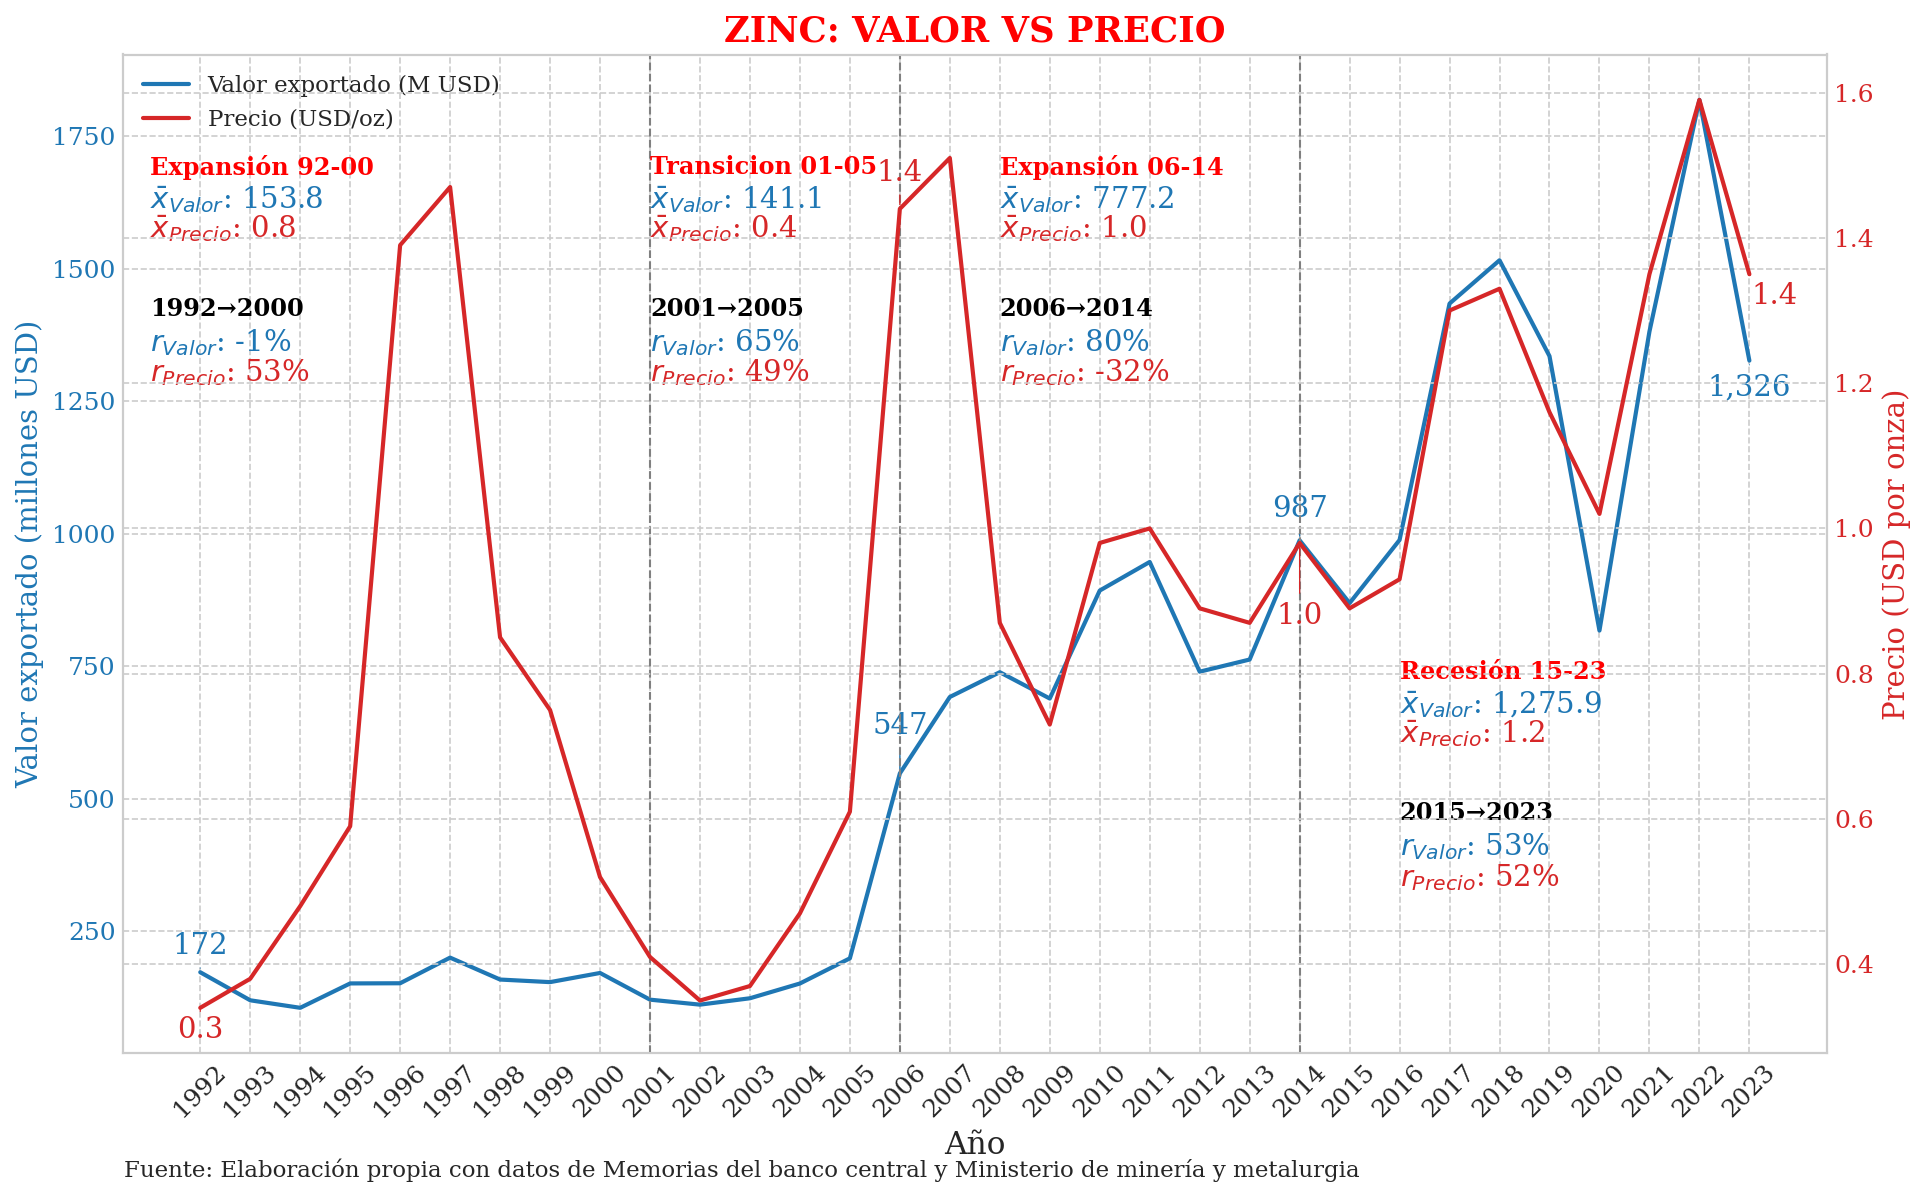

In [6]:
# ─────────────────────────────  PREPARACIÓN  ──────────────────────────────
import sys, os, sqlite3
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append(os.path.abspath('../'))
from graficos_utils import *
from func_auxiliares.config import *
# 0. Ciclos y carpetas

output_dir = "../../../../assets/tesis/serie_completa/minerales"
os.makedirs(output_dir, exist_ok=True)

set_style()

# 1. Datos ────────────────────────────────────────────────────────────────
with sqlite3.connect("../../../../db/proyectomacro.db") as conn:
    df_zinc = (pd.read_sql(
        "SELECT año, zinc_volumen, zinc_valor FROM exportaciones_minerales_totales "
        "WHERE año > 1991", conn)
        .set_index("año")
        .sort_index()
    )
    df_precio = (pd.read_sql(
        "SELECT año, zinc AS precio_usd_oz "
        "FROM precio_oficial_minerales WHERE año > 1991", conn)
        .set_index("año")
        .sort_index()
    )

df = df_zinc.join(df_precio, how="inner")
df["zinc_valor_musd"] = df["zinc_valor"] / 1_000     # miles → millones
df.drop(columns="zinc_valor", inplace=True)

# ───────────────────────  GRÁFICA DUAL AXIS (valor-precio) ───────────────────────
cols     = ["zinc_valor_musd", "precio_usd_oz"]
abbr     = {"zinc_valor_musd": "Valor", "precio_usd_oz": "Precio"}
colors   = {"zinc_valor_musd": "#1f77b4", "precio_usd_oz": "#d62728"}

cols_dual = ["zinc_valor_musd", "precio_usd_oz"]

CYCLES=adjust_cycles(df,CYCLES)
cycle_stats = {
    nombre: df.loc[rango, cols_dual].mean().to_dict()
    for nombre, rango in CYCLES.items()
}
anot_years=adjust_annot_years(df,annot_years)
growth_periods        = adjust_periods(df, periodos_tasas)

hitos_offset  = {yr: .60 for yr in hitos_v}

annotation_offsets = {
    "zinc_valor_musd": {
        1992:(0,50), 2000:(0,-80), 2006:(0,90), 2014:(0,60), 2023:(0,-50)
    },
    "precio_usd_oz": {
        1992:(0,-0.03),  2000:(0.13,0.08),  2006:(0,0.05), 2014:(0,-0.1), 2023:(0.5,-0.03)
    },
}

period_growth_offsets = {
    "1992-2000": (1991,0.76), "2001-2005":(2001,0.76),
    "2006-2014": (2008,0.76), "2015-2023":(2016,0.26)
}
cycle_text_offsets = {
    "Expansión 92-00": (1991,0.9),
    "Transicion 01-05":    (2001,0.9),
    "Expansión 06-14": (2008,0.9),
    "Recesión 15-23":  (2016,0.4),
}
# ──────────────────────  GRÁFICA DUAL AXIS (valor–precio) ───────────────────────
left_series  = [("zinc_valor_musd", "Valor exportado (M USD)")]
right_series = [("precio_usd_oz",    "Precio (USD/oz)")]

fig, ax_val, ax_price = init_dual_axis_plot(
    df=df,
    left_series=left_series,
    right_series=right_series,
    colors=colors,
    title=f"ZINC: VALOR VS PRECIO",
    xlabel="Año",
    left_ylabel="Valor exportado (millones USD)",
    right_ylabel="Precio (USD por onza)",
    source_text="Fuente: Elaboración propia con datos de Memorias del banco central y Ministerio de minería y metalurgia"
)
# helpers
add_hitos(ax_val, df.index, hitos_v, hitos_offset, line_kwargs={"linewidth":1})
add_cycle_means_multi(ax_val, cycle_stats, cycle_text_offsets,
                      abbr, colors, line_spacing=df["zinc_valor_musd"].max()*0.03,
                      value_fmt="{:,.1f}")
add_year_value_annotations(
    ax_val,   df, anot_years, ["zinc_valor_musd"],
    {"zinc_valor_musd": annotation_offsets["zinc_valor_musd"]},
    {"zinc_valor_musd": colors["zinc_valor_musd"]}, arrow_lw=0.6
)
add_year_value_annotations(
    ax_price, df, anot_years, ["precio_usd_oz"],
    {"precio_usd_oz": annotation_offsets["precio_usd_oz"]},
    {"precio_usd_oz": colors["precio_usd_oz"]}, arrow_lw=0.6,
    value_fmt="{:,.1f}"
)
add_period_growth_annotations_multi(
    ax_val, df, growth_periods, cols,
    period_growth_offsets, colors, abbr
)


# leyenda filtrada
h,l = ax_val.get_legend_handles_labels()
h2,l2 = ax_price.get_legend_handles_labels()
hl = [(x,y) for x,y in zip(h+h2,l+l2) if not y.startswith('_')]
if hl: ax_val.legend(*zip(*hl), loc="upper left", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir,"zinc_valor_precio_dual_axis.png"), dpi=300)
plt.show()



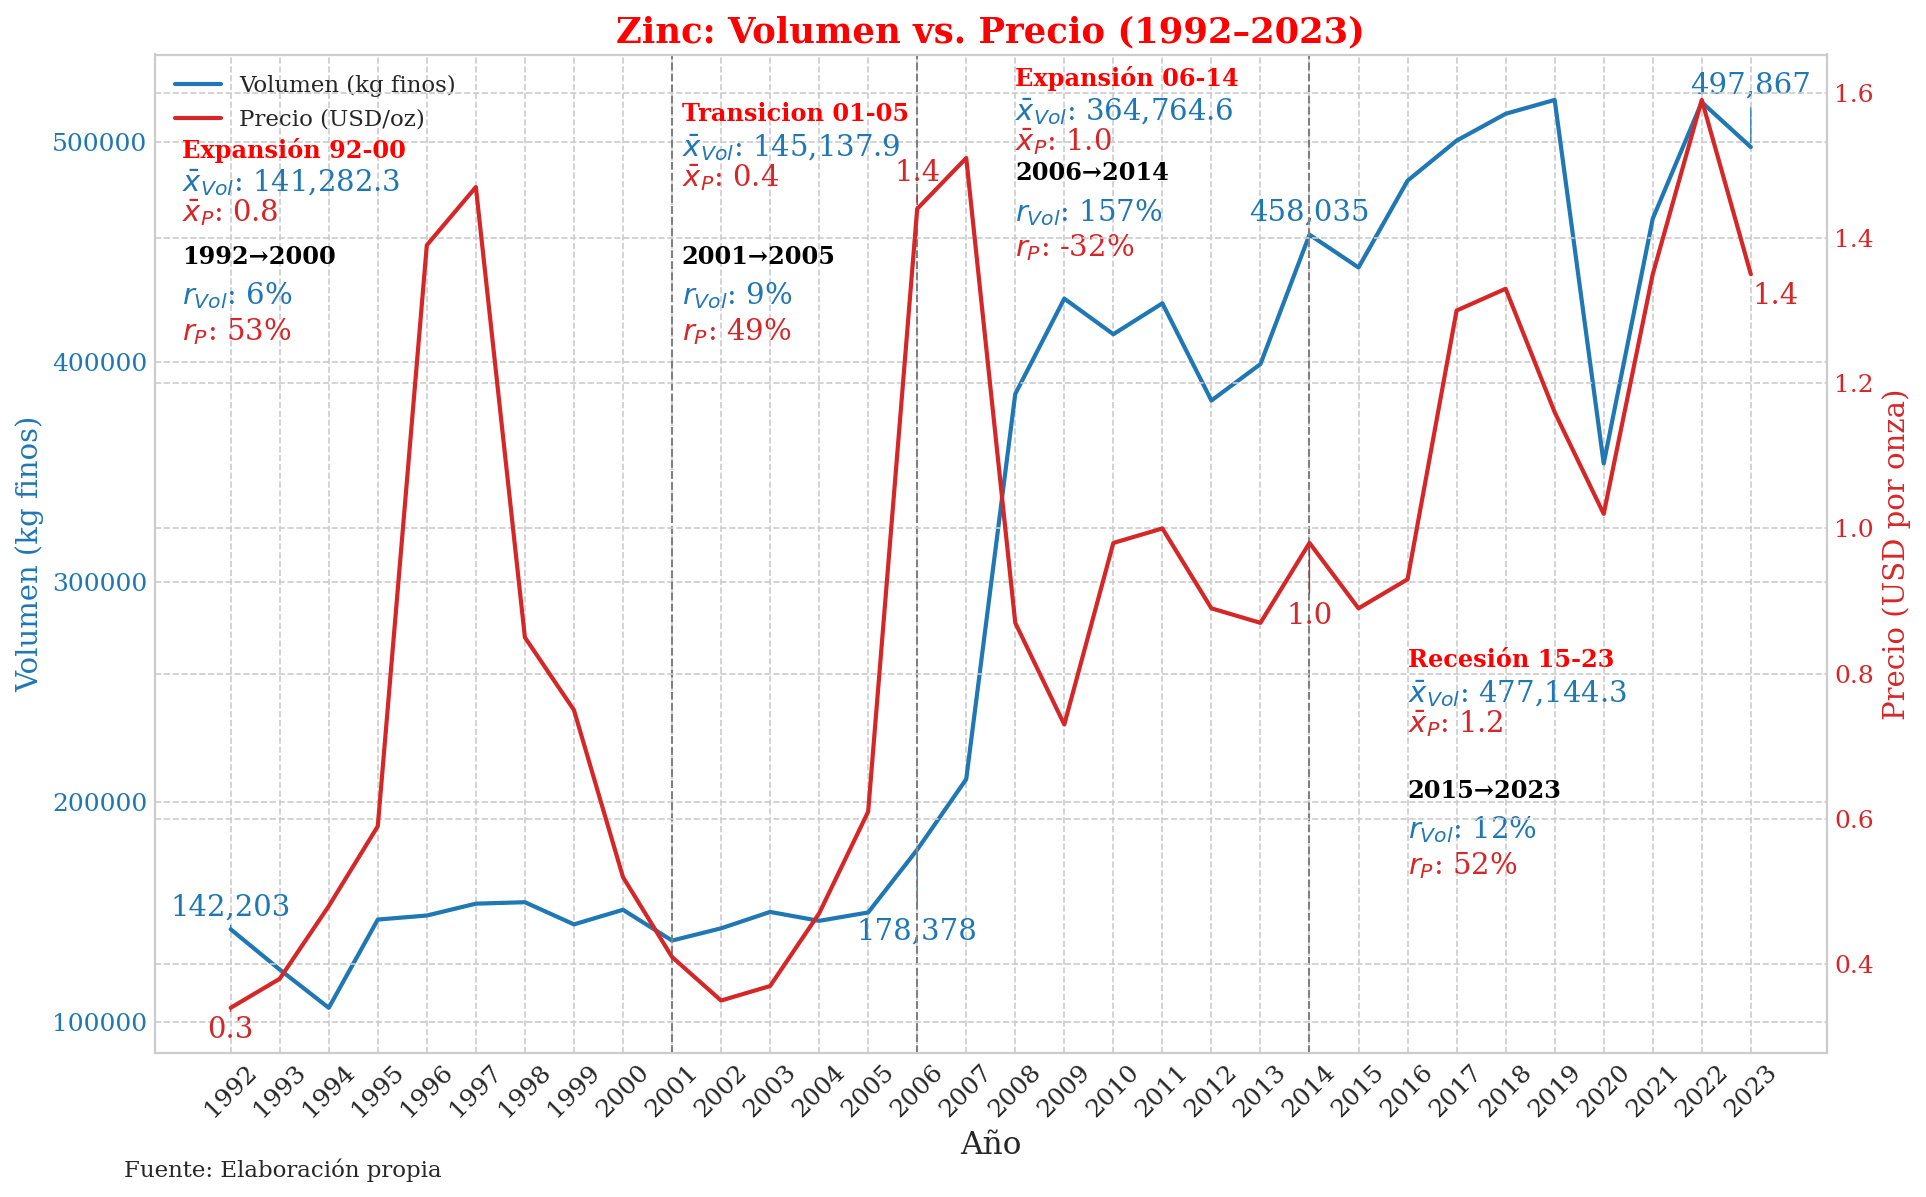

In [11]:
# ──────────────────  GRÁFICA DUAL AXIS (volumen-precio) ──────────────────
cols_vol   = ["zinc_volumen", "precio_usd_oz"]
colors_vol = {
    "zinc_volumen": "tab:blue",
    "precio_usd_oz": colors["precio_usd_oz"]       # rojo definido antes
}
abbr_vol = {"zinc_volumen": "Vol", "precio_usd_oz": "P"}

cycle_stats_vol = {
    n: df.loc[s, cols_vol].mean().to_dict()
    for n, s in CYCLES.items()
}

annotation_offsets_vol = {
    "zinc_volumen": {
        1992:(0,1e4), 2000:(-0.5,-2.2e4), 2006:(0,-3.7e4),
        2014:(0,1e4), 2023:(0,2.8e4)
    },
    "precio_usd_oz": {
        1992:(0,-0.03), 2000:(0.13,0.08), 2006:(0,0.05),
        2014:(0,-0.1),  2023:(0.5,-0.03)
    }
}

period_growth_offsets_vol = {
    "1992-2000": (1991,0.84), "2001-2005":(2001.2,0.84),
    "2006-2014": (2008,0.91), "2015-2023":(2016,0.39)
}

cycle_text_offsets_vol = {
    "Expansión 92-00": (1991,0.93),
    "Transicion 01-05":    (2001.2,0.96),
    "Expansión 06-14": (2008,0.99),
    "Recesión 15-23":  (2016,0.50),
}
# ──────────────────────  GRÁFICA DUAL AXIS (volumen–precio) ─────────────────────
left_series_vol  = [("zinc_volumen", "Volumen (kg finos)")]
right_series_vol = [("precio_usd_oz",  "Precio (USD/oz)")]

fig_v, ax_v, ax_price_v = init_dual_axis_plot(
    df=df,
    left_series=left_series_vol,
    right_series=right_series_vol,
    colors=colors_vol,
    title=f"Zinc: Volumen vs. Precio ({df.index[0]}–{df.index[-1]})",
    xlabel="Año",
    left_ylabel="Volumen (kg finos)",
    right_ylabel="Precio (USD por onza)"
)

# hitos
add_hitos(ax_v, df.index, hitos_v, hitos_offset, line_kwargs={"lw":1})

# espaciado relativo
y_min, y_max = ax_v.get_ylim()
line_spacing = (y_max - y_min) * 0.03

# medias por ciclo
add_cycle_means_multi(
    ax_v, cycle_stats_vol, cycle_text_offsets_vol,
    abbr_vol, colors_vol, line_spacing=line_spacing,
    value_fmt="{:,.1f}"
)

# anotaciones de año
add_year_value_annotations(
    ax_v, df, anot_years, ["zinc_volumen"],
    {"zinc_volumen": annotation_offsets_vol["zinc_volumen"]},
    {"zinc_volumen": colors_vol["zinc_volumen"]}, arrow_lw=0.6
)
add_year_value_annotations(
    ax_price_v, df, anot_years, ["precio_usd_oz"],
    {"precio_usd_oz": annotation_offsets_vol["precio_usd_oz"]},
    {"precio_usd_oz": colors_vol["precio_usd_oz"]}, arrow_lw=0.6,
    value_fmt="{:,.1f}"
)

# tasas de crecimiento
add_period_growth_annotations_multi(
    ax_v, df, growth_periods, cols_vol,
    period_growth_offsets_vol, colors_vol, abbr_vol,
    line_spacing_ratio=0.03
)


h1,l1 = ax_v.get_legend_handles_labels()
h2,l2 = ax_price_v.get_legend_handles_labels()
ax_v.legend(h1+h2, l1+l2, loc="upper left", fontsize=11)

plt.tight_layout()
plt.savefig(os.path.join(output_dir, "zinc_volumen_precio_dual_axis.png"), dpi=300)
plt.show()
